# CMA/ES - Bays09 - 12th try: EM fits MSE scaled

Trying out the new scaled MSE emfit. Perhaps worst for histograms?

In [66]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [85]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [86]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_12try_emfitscaled_Mratiosigmaxsigmabaselinelapserate_repetitions3_100118/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-8b4a8ca0-eef2-443e-a9db-d295232c9925.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_12try_emfitscaled_Mratiosigmaxsigmabaselinelapserate_repetitions3_100118


In [87]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [88]:
parameter_names_sorted

['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [89]:
metric = 'dist_emfit_scaled'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])
df_all_fits[metric + "_log"] = np.log(df_all_fits[metric])

In [90]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [91]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 200

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

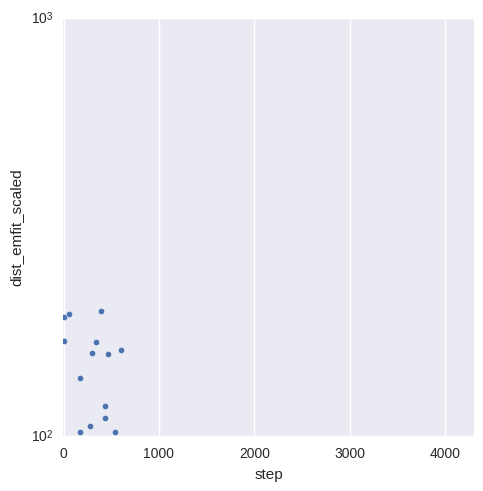

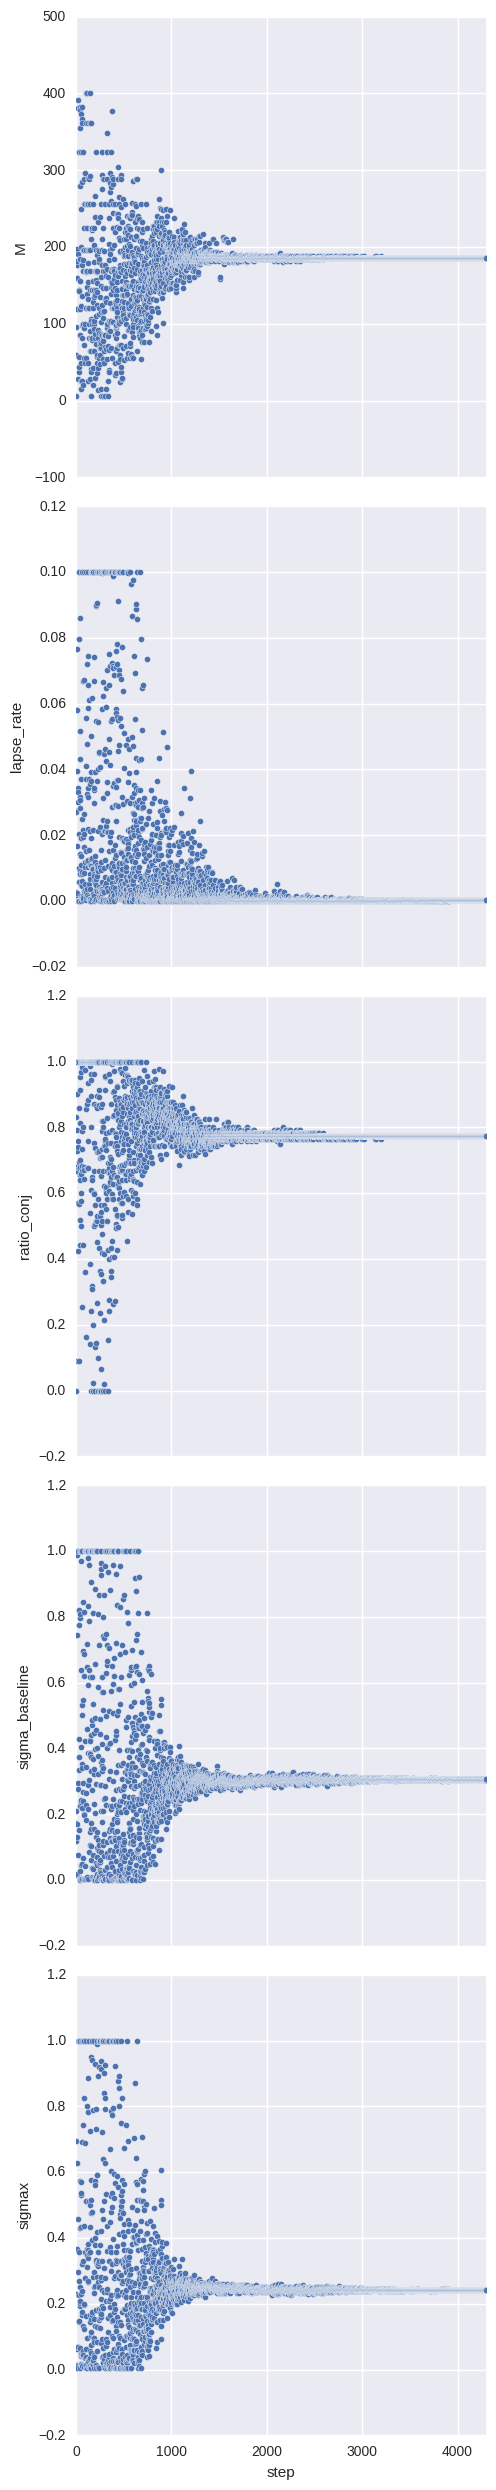

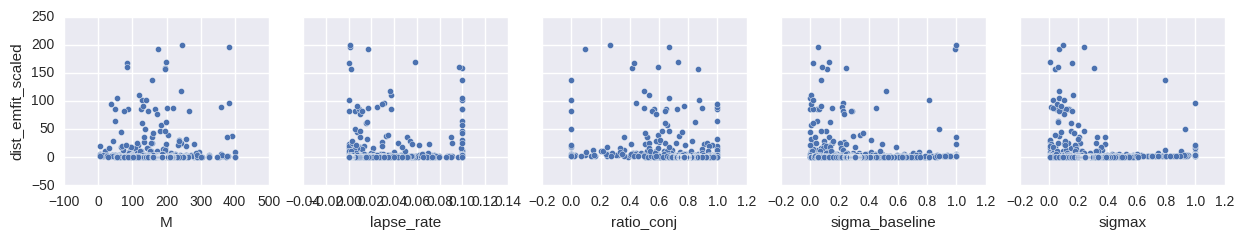

In [111]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))
g.set(yscale = 'log')


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



In [97]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] < 1000]
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.array(df_cmaes_traj['dist_nll92'])
# result_to_color = np.log(result_to_color)

parameters = ['M', 'lapse_rate', 'sigma_baseline']
parameters = ['ratio_conj', 'sigmax', 'sigma_baseline']

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj[parameters[0]],
        y = df_cmaes_traj[parameters[1]],
        z = df_cmaes_traj[parameters[2]],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title=parameters[0],
        ),
        yaxis=go.YAxis(
            title=parameters[1],
        ),
        zaxis=go.ZAxis(
            title=parameters[2],
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [104]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(1).median().to_dict()
df_bestparams = df_best_fits.sort_values(by=metric).iloc[2].to_dict()
df_bestparams

{'M': 186.0,
 'dist_emfit_scaled': 0.0073627719520494139,
 'dist_emfit_scaled_log': -4.9113187932265809,
 'lapse_rate': 0.00061197899763598511,
 'ratio_conj': 0.77419354838709675,
 'sigma_baseline': 0.30748621782526298,
 'sigmax': 0.23841215704012636,
 'step': 2354.0}

In [113]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             num_repetitions=1,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=1500, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

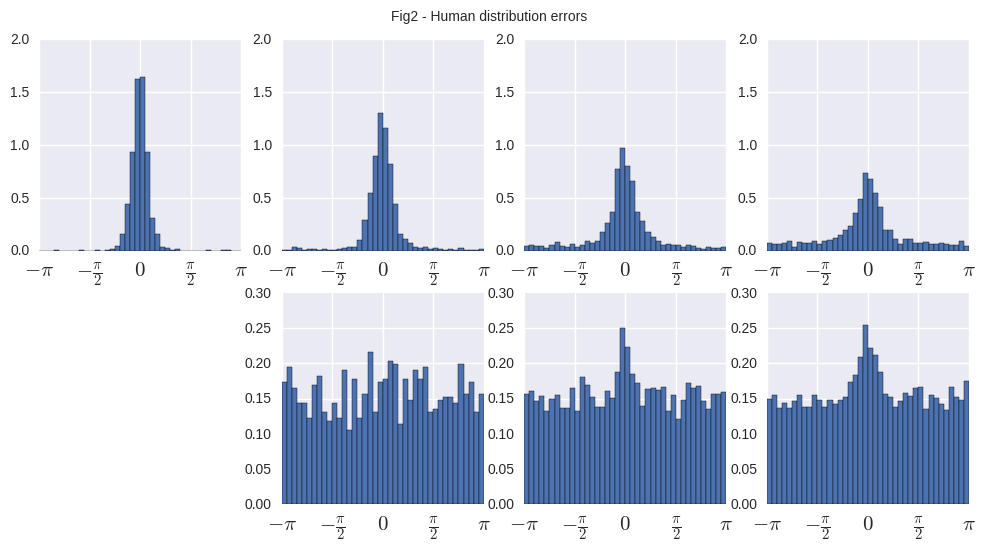

In [114]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

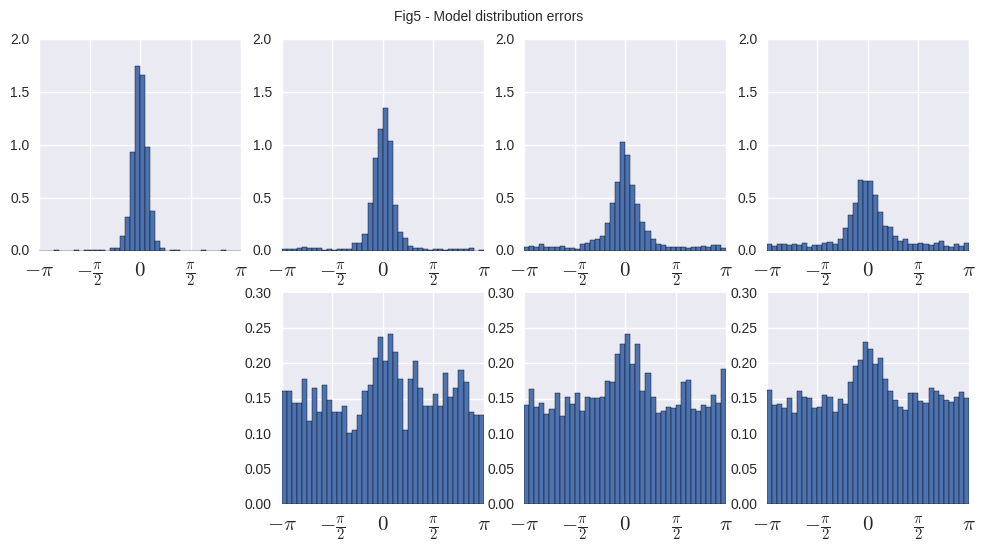

In [115]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

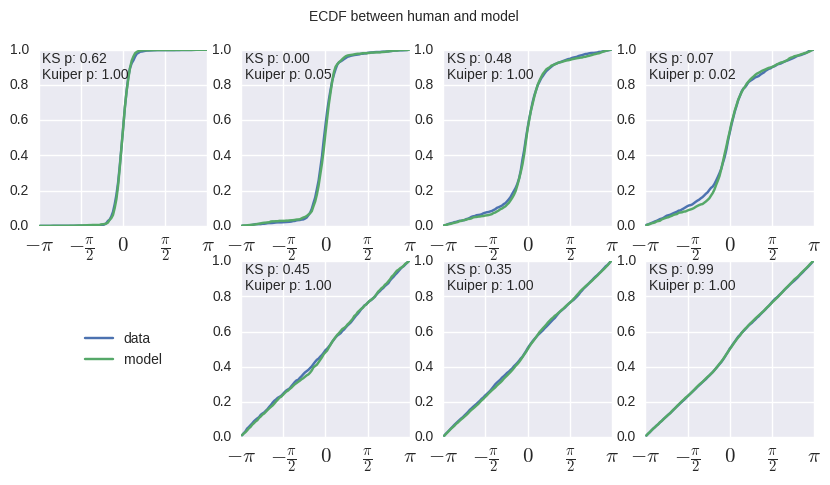

In [116]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, ks_out = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((10, 5))

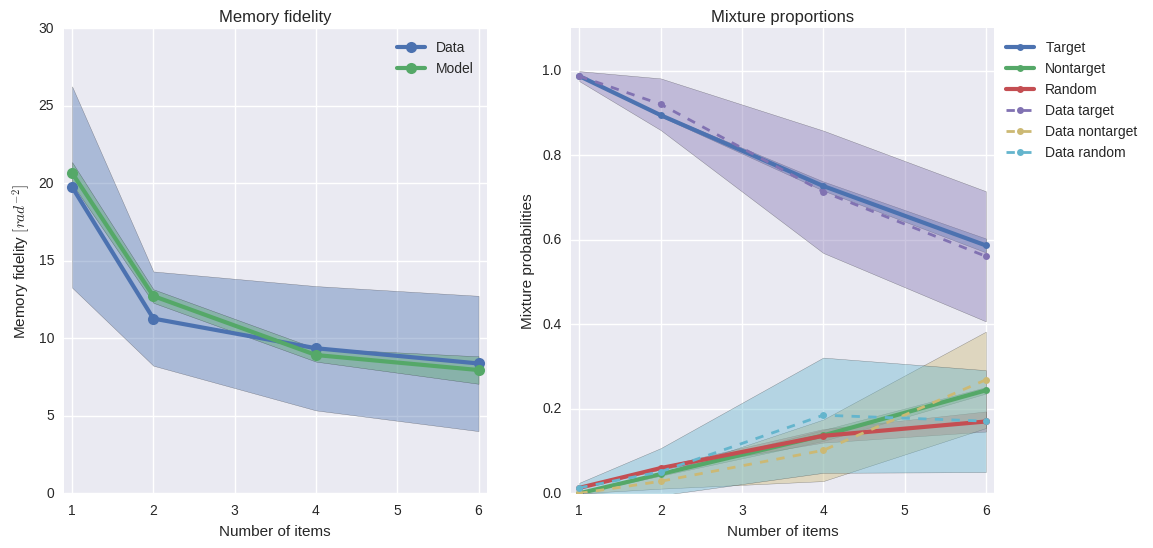

In [117]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True, layout='horizontal')
#     axesFig6Fig13[0].figure.set_size_inches((5, 10))

In [120]:
print "BIC, lower better."
print np.nanmean(results['result_bic'], axis=-1)
print np.sum(np.nanmean(results['result_bic'], axis=-1))

print "NLL, lower better"
print np.nanmean(-results['result_ll_sum'], axis=-1)
print np.sum(np.nanmean(-results['result_ll_sum'], axis=-1))

BIC, lower better.
[ 2509.07281163  4090.0969018   5601.03682642  6253.60338569]
18453.8099256
NLL, lower better
[ 1239.90996504  2030.42201013  2785.89197244  3112.17525207]
9168.39919968


In [130]:
curr_params_fit = fit_exp.sampler.fit_mixture_model(
    use_all_targets=False)
result_em_fits = np.array([
    curr_params_fit[key]
    for key in [
        'kappa', 'mixt_target', 'mixt_nontargets_sum',
        'mixt_random', 'train_LL', 'bic'
    ]
])
emfits_distances = fit_exp.compute_dist_experimental_em_fits_currentT(
                    result_em_fits)
np.sum(emfits_distances['mse_scaled'])

0.0020838246021107451

# ANALYSE ME

In [119]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_bays09_llmedian', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs/thesis_bays09_llmedian-754f983d-badf-4b7d-98c8-7af5328785eb ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_sigmabaseline_cmaes_08_2016/fitexperiment_sigmabaseline_cmaes_08_2016_cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/g

In [28]:
axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_human_{label}_{unique_id}.pdf"))
axesFig5[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_model_{label}_{unique_id}.pdf"))
axes[0, 0].figure.savefig(dataio.create_formatted_filename("ecdf_model_{label}_{unique_id}.pdf"))
axesFig6Fig13[0].figure.savefig(dataio.create_formatted_filename("emfits_model_{label}_{unique_id}.pdf"))

## Population of best network

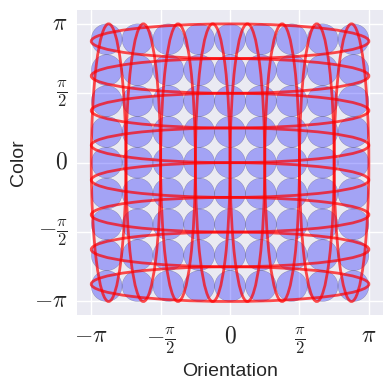

In [117]:
rn = fit_exp.sampler.random_network

axPopulation = rn.plot_coverage_feature_space(
    nb_stddev=1, alpha_ellipses=0.3, specific_neurons=np.arange(81), facecolor='b', lim_factor=1.1)
rn.plot_coverage_feature_space(
    nb_stddev=1, alpha_ellipses=0.7, specific_neurons=np.arange(81, 89), facecolor='none', 
    edgecolor='r', linewidth=2, lim_factor=1.1, ax=axPopulation, scale_height=2)
rn.plot_coverage_feature_space(
    nb_stddev=1, alpha_ellipses=0.7, specific_neurons=np.arange(89, 97), facecolor='none', 
    edgecolor='r', linewidth=2, lim_factor=1.1, ax=axPopulation, scale_width=2)


In [120]:
axPopulation.figure.savefig(dataio.create_formatted_filename("population_{label}_{unique_id}.pdf"))

## Distance effect

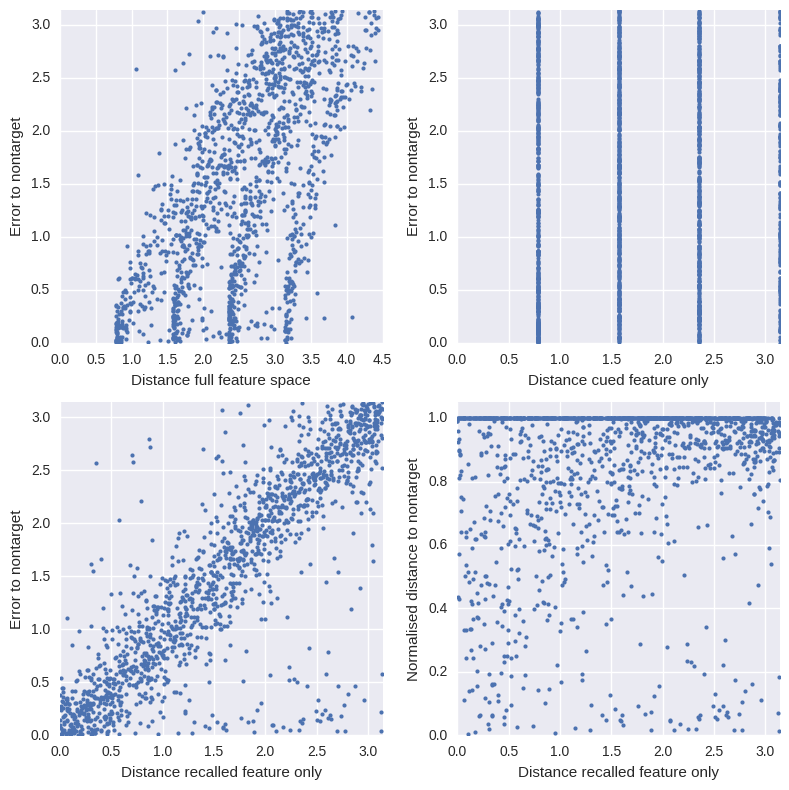

In [196]:
# With experimental data
fit_exp.setup_experimental_stimuli_T(2)
axes_dist = fit_exp.sampler.plot_bias_close_feature()

In [190]:
# Reproduce with random data, same parameters
experiment_parameters = dict(action_to_do='launcher_do_simple_run',
                             inference_method='sample',
                             selection_method='last',
                             N=2000,
                             T=2,
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             num_repetitions=1,
                             enforce_min_distance=0.4,
                             stimuli_generation_recall='random',
                             enforce_distance_cued_feature_only=None,
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    sampler = experiment_launcher.all_vars['sampler']
        

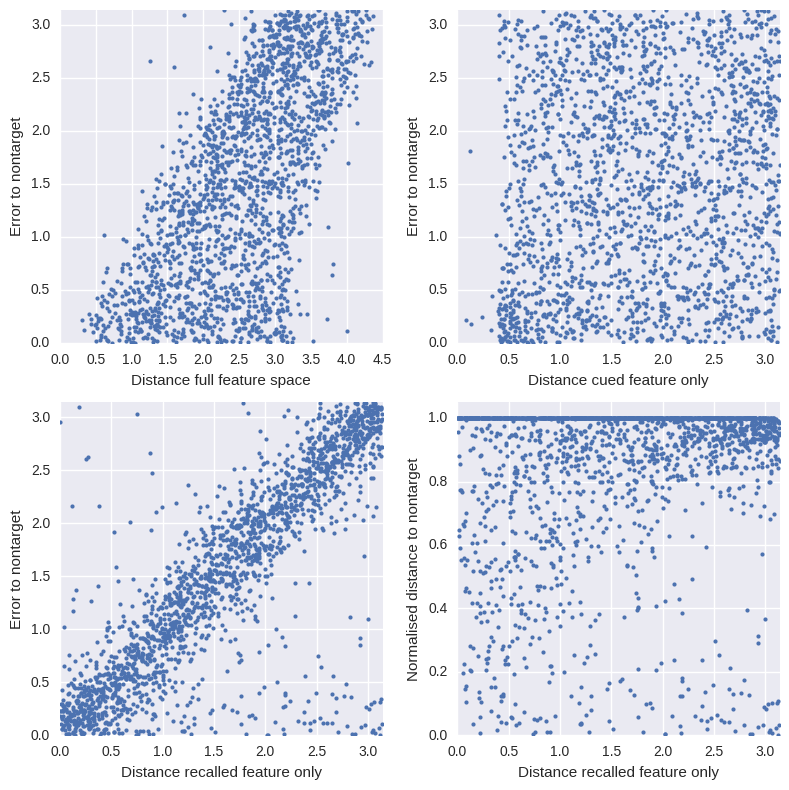

In [193]:
# Fitted model
axes_dist_best_mixed = sampler.plot_bias_close_feature()